<a href="https://colab.research.google.com/github/Ge0f3/tensorflow_certification/blob/main/Milestone_Project_Food_Vision_Big%E2%84%A2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Food Vision Big™ Project Milestone project 

### Initial Setup 

In [1]:
# Hide warning logs (see: https://stackoverflow.com/a/38645250/7900723)
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# Check TensorFlow version (should be 2.4.0+)
import tensorflow as tf
print(tf.__version__)
tf.config.run_functions_eagerly(True)

2.8.2


In [2]:
! nvidia-smi 

Tue Sep  6 16:39:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Get helper functions file
if not os.path.exists("helper_functions.py"):
    print("Downloading helper functions...")
    !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
else:
    print("Helper functions file already exists, skipping download...")

Helper functions file already exists, skipping download...


In [4]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

### Dataset

In [5]:
import tensorflow_datasets as tfds

dataset_list = tfds.list_builders()

print('food101' in dataset_list)

True


In [6]:
(train_data,test_data),ds_info = tfds.load(name = 'food101',
                                           split=['train','validation'],
                                           shuffle_files=True,
                                           as_supervised= True,
                                           with_info=True
                                           )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [28]:
len(ds_info.features["label"].names)

101

In [7]:
# Get class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [8]:
import numpy as np 
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from 'uint8' -> 'float32' and reshapes image to
  [img_shape, img_shape, color_channels]
  """
  image = np.expand_dims(image.numpy(), axis=0)
  
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape

 
  return tf.cast(image, tf.float32), label # return (float32_image, label) tuple


In [9]:
# Take one sample off the training data
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)

In [10]:
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [11]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 90
  Class name (str form): spaghetti_bolognese
        


In [12]:
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")


Image before preprocessing:
 [[[12 13  7]
  [12 13  7]
  [13 14  8]
  ...
  [21 11  0]
  [21 11  0]
  [21 11  0]]

 [[12 13  7]
  [11 12  6]
  [11 12  6]
  ...
  [21 11  0]
  [21 11  0]
  [21 11  0]]]...,
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[[1.1586735e+01 1.2586735e+01 6.5867348e+00]
   [1.1714286e+01 1.2714286e+01 6.7142859e+00]
   [8.8571424e+00 9.8571424e+00 4.8571424e+00]
   ...
   [2.0714308e+01 1.1142836e+01 1.2857144e+00]
   [2.0668371e+01 1.0668372e+01 0.0000000e+00]
   [2.1000000e+01 1.1000000e+01 0.0000000e+00]]

  [[2.3571415e+00 3.3571415e+00 1.4285660e-01]
   [3.1530607e+00 4.1530604e+00 7.6530300e-02]
   [3.0561223e+00 4.0561223e+00 0.0000000e+00]
   ...
   [2.6071407e+01 1.8071407e+01 7.0714073e+00]
   [2.4785702e+01 1.4785702e+01 4.7857018e+00]
   [2.2499966e+01 1.2499966e+01 2.4999657e+00]]

  [[1.3520410e+00 2.3520410e+00 0.0000000e+00]
   [3.0408170e+00 4.0408173e+00 6.1224538e-01]
   [7.2346954e+00 8.1887770e+00 3.3265321

In [13]:
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 12,  13,   7],
        [ 12,  13,   7],
        [ 13,  14,   8],
        ...,
        [ 21,  11,   0],
        [ 21,  11,   0],
        [ 21,  11,   0]],

       [[ 12,  13,   7],
        [ 11,  12,   6],
        [ 11,  12,   6],
        ...,
        [ 21,  11,   0],
        [ 21,  11,   0],
        [ 21,  11,   0]],

       [[  7,   8,   2],
        [  7,   8,   2],
        [  7,   8,   2],
        ...,
        [ 22,  12,   2],
        [ 21,  11,   1],
        [ 20,  10,   0]],

       ...,

       [[188, 191, 184],
        [188, 191, 184],
        [188, 191, 184],
        ...,
        [243, 248, 244],
        [243, 248, 244],
        [242, 247, 243]],

       [[187, 190, 183],
        [189, 192, 185],
        [190, 193, 186],
        ...,
        [241, 245, 244],
        [241, 245, 244],
        [241, 245, 244]],

       [[186, 189, 182],
        [189, 192, 185],
        [191, 194, 187],
        ...,
        [238, 242, 24

In [14]:
# What are the min and max values?
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

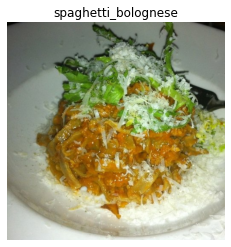

In [15]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # add title to image by indexing on class_names list
plt.axis(False);

In [16]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from 'uint8' -> 'float32' and reshapes image to
  [img_shape, img_shape, color_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
  return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [17]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [18]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

### callback function 

In [47]:
# Create TensorBoard callback (already have "create_tensorboard_callback()" from a previous notebook)
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      montior="val_accuracy", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=1) # don't print out whether or not model is being saved 

### Setup mixed precision training

In [20]:
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy(policy='mixed_float16')

In [22]:
mixed_precision.global_policy()

<Policy "mixed_float16">

### Data Augmentation

In [25]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential


data_augmentation = Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2)
],
name = 'data_augmentation'
)

### Base Model

In [55]:
#Base model 
base_model = tf.keras.applications.EfficientNetB1(include_top=False)
base_model.trainable = False


# Setup the input architecture 

inputs = layers.Input(shape=(224,224,3),name='input_layer',dtype=tf.float16)
x = data_augmentation(inputs)
x = base_model(x,training=False)
x = layers.GlobalAveragePooling2D(name = "global_average_pooling")(x)
outputs = layers.Dense(len(ds_info.features["label"].names),activation = 'softmax',name = 'output_layer')(x)

model = tf.keras.Model(inputs,outputs)

In [56]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # Check the dtype policy of layers


input_layer True float16 <Policy "float16">
data_augmentation True float32 <Policy "mixed_float16">
efficientnetb1 False float32 <Policy "mixed_float16">
global_average_pooling True float32 <Policy "mixed_float16">
output_layer True float32 <Policy "mixed_float16">


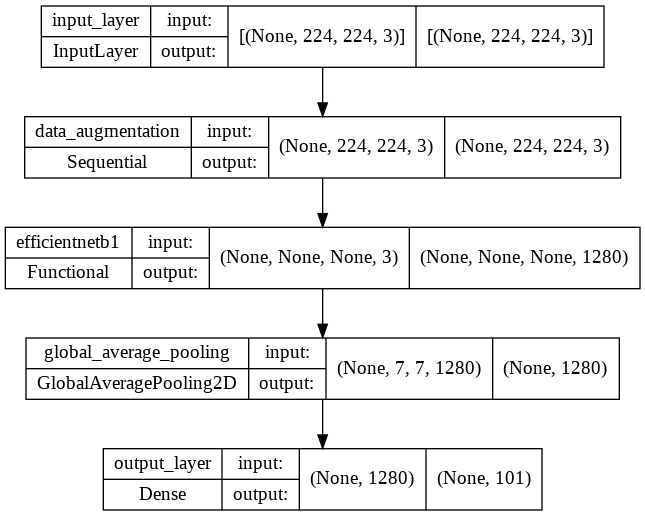

In [57]:
tf.keras.utils.plot_model(model,show_shapes=True)

In [58]:
# Compile the model 

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

In [ ]:
# Fit the model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data, 
                                                     epochs=3,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback("training_logs", 
                                                                                            "efficientnetb0_101_classes_all_data_feature_extract"),
                                                                checkpoint_callback])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20220906-175451
Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 2.2702 - accuracy: 0.4573
Epoch 1: val_loss improved from inf to 1.39432, saving model to model_checkpoints/cp.ckpt
2368/2368 [==============================] - 1519s 641ms/step - loss: 2.2702 - accuracy: 0.4573 - val_loss: 1.3943 - val_accuracy: 0.6298
Epoch 2/3
2368/2368 [==============================] - ETA: 0s - loss: 1.7910 - accuracy: 0.5476
Epoch 2: val_loss improved from 1.39432 to 1.28990, saving model to model_checkpoints/cp.ckpt
2368/2368 [==============================] - 1227s 517ms/step - loss: 1.7910 - accuracy: 0.5476 - val_loss: 1.2899 - val_accuracy: 0.6459
Epoch 3/3
1498/2368 [=================>............] - ETA: 6:49 - loss: 1.6778 - accuracy: 0.5720

In [60]:
model.evaluate(test_data)

790/790 [==============================] - 204s 258ms/step - loss: 1.2907 - accuracy: 0.6503


[1.2907483577728271, 0.650257408618927]

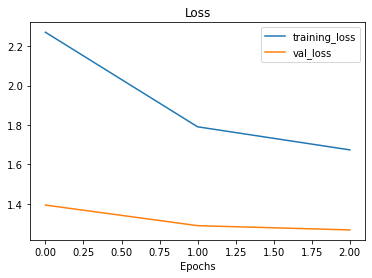

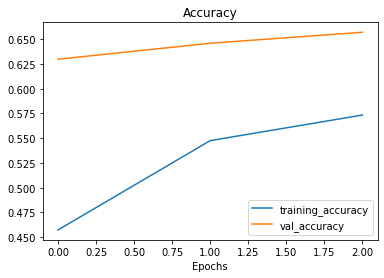

In [61]:
plot_loss_curves(history_101_food_classes_feature_extract)